# Wrangle SaaS Data

Here we will acquire data from a mySQL database. The connection details are hidden in the env python module, and you can see the SQL query used in the cell below.


In [17]:
import pandas as pd
import env
import matplotlib.pyplot as plt
import os
import seaborn as sns

url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/saas_llc'
query = '''
select cust.customer_id
    , cust.latitude
    , cust.longitude
    , cust.city
    , cust.state
    , cust.district
    , churn.churn_month
    , su.signup_month
    , inv.invoice_month
    , inv.invoice_id
    , inv.amount
    , sub.subscription_desc
    , sub.subscription_price
    , sub.subscription_available
from customer_details cust
right join invoice inv on cust.customer_id = inv.customer_id
left join churn on inv.customer_id = churn.customer_id
left join signup su on inv.customer_id = su.customer_id
left join subscription sub on inv.subscription_id = sub.subscription_id;
'''

# df = pd.read_sql(query, url)
# df.to_csv("saas.csv")

In [18]:
def get_saas_data():
    filename = "saas.csv"

    if os.path.isfile(filename):
        return pd.read_csv(filename)
    else:
        # read the SQL query into a dataframe
        df = pd.read_sql(query, url)

        # Write that dataframe to disk for later. Called "caching" the data for later.
        df.to_file(filename)

        # Return the dataframe to the calling code
        return df  

Run the function above, that acquires the csv if it has been cached locally and saved, or acquires the data from the sql database using the query above, if the data has not been cached and saved locally. 

In [19]:
df = get_saas_data()

In [20]:
df.head(5)

,Unnamed: 0,customer_id,latitude,longitude,city,state,district,churn_month,signup_month,invoice_month,invoice_id,amount,subscription_desc,subscription_price,subscription_available
0,0,1000000,42.001949,-70.915455,EAST BRIDGEWATER,MA,PLYMOUTH,2014-12-31,2014-01-31,2014-01-31,5000000,0,free,0.0,1
1,1,1000002,42.351153,-71.058183,BOSTON,MA,SUFFOLK,2017-08-31,2014-01-31,2014-01-31,5000002,0,free,0.0,1
2,2,1000004,42.458185,-70.935629,LYNN,MA,ESSEX,2015-09-30,2014-01-31,2014-01-31,5000004,10,smb,10.0,1
3,3,1000005,41.737983,-70.192834,DENNIS,MA,BARNSTABLE,2014-09-30,2014-01-31,2014-01-31,5000005,0,free,0.0,1
4,4,1000006,42.717089,-71.181776,LAWRENCE,MA,ESSEX,2015-03-31,2014-01-31,2014-01-31,5000006,20,corporate,20.0,1


Q: Where are these customers located? 

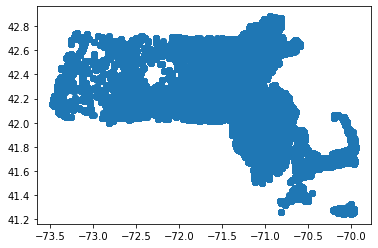

In [15]:
plt.scatter(x=df.longitude, y=df.latitude)
plt.show()

Massachusetts

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 791302 entries, 0 to 791301
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   customer_id             791302 non-null  int64  
 1   latitude                791302 non-null  float64
 2   longitude               791302 non-null  float64
 3   city                    791302 non-null  object 
 4   state                   791302 non-null  object 
 5   district                791302 non-null  object 
 6   churn_month             293366 non-null  object 
 7   signup_month            791302 non-null  object 
 8   invoice_month           791302 non-null  object 
 9   invoice_id              791302 non-null  int64  
 10  amount                  791302 non-null  int64  
 11  subscription_desc       791302 non-null  object 
 12  subscription_price      791302 non-null  float64
 13  subscription_available  791302 non-null  int64  
dtypes: float64(3), int64

How many have churned? 

In [41]:
n_churned_customers = df[df.churn_month.notna()].customer_id.nunique()
n_customers = df.customer_id.nunique()

print("{} customers have churned of {} total customers".format(n_churned_customers, n_customers))
print("{churn_pct:.2f}% have churned".format(churn_pct = n_churned_customers/n_customers*100))

15513 customers have churned of 29400 total customers
52.77% have churned


How is churn defined? If a customer has a 0 invoice month, does that indicate churn? 
We will count the number of customers with at least one 0 month and see if that number is equal to the number of churned customers. 

In [48]:
min_amount = df.groupby(['customer_id'])['amount'].min()


In [52]:
n_customers_with_a_zero_month = len(min_amount[min_amount == 0])

print("{} customers have at least one month of $0 of {} total customers".format(n_customers_with_a_zero_month, 
                                                                                n_customers))
print("{zero_pct:.2f}% of customers have at least one month of $0".format(zero_pct = 
                                                                          n_customers_with_a_zero_month/n_customers*100))

24367 customers have at least one month of $0 of 29400 total customers
82.88% of customers have at least one month of $0


Let's convert data types and drop some unnecessary columns

In [58]:
df['churn_month'] = pd.to_datetime(df.churn_month, yearfirst=True)
df['signup_month'] = pd.to_datetime(df.signup_month, yearfirst=True)
df['invoice_month'] = pd.to_datetime(df.invoice_month, yearfirst=True)

In [62]:
df.drop(columns = ['Unnamed: 0', 'latitude', 'longitude', 'city'], inplace=True)

Next, summarize each column of data. 

In [78]:
numeric_cols = ['amount', 'subscription_price', 'subscription_available']
cat_cols = ['subscription_desc', 'state', 'district']
date_cols = ['churn_month', 'signup_month', 'invoice_month']

In [79]:
df[numeric_cols].describe()

,amount,subscription_price,subscription_available
count,791302.000000,791302.000000,791302.0
mean,2.971179,2.971179,1.0
std,4.731037,4.731037,0.0
min,0.000000,0.000000,1.0
25%,0.000000,0.000000,1.0
50%,0.000000,0.000000,1.0
75%,5.000000,5.000000,1.0
max,20.000000,20.000000,1.0


**Takeaways**

- subscription_available has no entropy. All values are 1. Drop column. 
- amount and subscription_price represent the same values. Drop subscription_price. 

In [80]:
df[date_cols].describe(include='all')

<ipython-input-80-ce652dca41b5>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df[date_cols].describe(include='all')
<ipython-input-80-ce652dca41b5>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df[date_cols].describe(include='all')
<ipython-input-80-ce652dca41b5>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df[date_cols].describe(include='all')


,churn_month,signup_month,invoice_month
count,293366,791302,791302
unique,47,48,48
top,2017-09-30 00:00:00,2014-01-31 00:00:00,2014-01-31 00:00:00
freq,10340,621719,20000
first,2014-01-31 00:00:00,2014-01-31 00:00:00,2014-01-31 00:00:00
last,2017-11-30 00:00:00,2017-12-31 00:00:00,2017-12-31 00:00:00


**Takeaways**

- Our data goes from start of 2014 through end of 2017. 
- Look at those who have churned to see what the data shows for their amount and their plan. Do customers have a way to notify they are churning or do they change from a paid plan to a churn plan? Or does their invoice amount go to 0? 

In [83]:
df[cat_cols].describe(include='all')

,subscription_desc,state,district
count,791302,791302,791302
unique,5,1,14
top,free,MA,MIDDLESEX
freq,499033,791302,175238


In [88]:
df.groupby(['subscription_desc'])['amount'].agg(['min','max'])

,min,max
subscription_desc,,
corporate,20,20
free,0,0
reseller,15,15
smb,10,10
student,5,5


In [93]:
df.groupby(['subscription_desc'])['district'].nunique()

subscription_desc
corporate    14
free         14
reseller     14
smb          14
student      14
Name: district, dtype: int64

**Takeaways**

- All are in massachusetts. Drop 'state' column.
- Vast majority of subscriptions are free. Can accounts change from free to reseller/corporate and back? 
- types of subscriptions: free (\\$0), student (\\$5), smb (\\$10), reseller (\\$15), corporate (\\$20)

In [94]:
df

,customer_id,city,state,district,churn_month,signup_month,invoice_month,invoice_id,amount,subscription_desc,subscription_price,subscription_available
0,1000000,EAST BRIDGEWATER,MA,PLYMOUTH,2014-12-31,2014-01-31,2014-01-31,5000000,0,free,0.0,1
1,1000002,BOSTON,MA,SUFFOLK,2017-08-31,2014-01-31,2014-01-31,5000002,0,free,0.0,1
2,1000004,LYNN,MA,ESSEX,2015-09-30,2014-01-31,2014-01-31,5000004,10,smb,10.0,1
3,1000005,DENNIS,MA,BARNSTABLE,2014-09-30,2014-01-31,2014-01-31,5000005,0,free,0.0,1
4,1000006,LAWRENCE,MA,ESSEX,2015-03-31,2014-01-31,2014-01-31,5000006,20,corporate,20.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
791297,1029333,NEWTON,MA,MIDDLESEX,NaT,2017-12-31,2017-12-31,5791235,0,free,0.0,1
791298,1029341,WORCESTER,MA,WORCESTER,NaT,2017-12-31,2017-12-31,5791243,0,free,0.0,1
791299,1029347,EAST BOSTON,MA,SUFFOLK,NaT,2017-12-31,2017-12-31,5791249,10,smb,10.0,1
791300,1029364,BRIGHTON,MA,SUFFOLK,NaT,2017-12-31,2017-12-31,5791266,0,free,0.0,1


What is the last month of invoices on record? 


I want to generate some new features that describe the patterns in customers' monthly invoices. 

- number of months with $0
- number of months 

Drop unnecessary columns

In [ ]:
drop_cols = ['Unnamed: 0', 'latitude', 'longitude']
df.drop(columns )

Ho

In [ ]:
df.